# NBA realtime gametime
### Replicating inpredictable's 'How long is each minute of NBA gametime' using my own pbp date
https://www.inpredictable.com/2014/04/how-long-is-each-minute-of-nba-gametime.html

In [ ]:
# !pip install nba_api

In [2]:
"""for a SINGLE GAME, how many realtime minutes does each minute of gametime take"""

"""get every game_id from the 23-24 season"""
from nba_api.stats.endpoints import leaguegamefinder
gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable='00', season_nullable='2023-24', season_type_nullable='Regular Season')
all_games = gamefinder.get_data_frames()[0]

"""this is from each team's perspective, get a list of every unique game_id, order doesn't matter"""
all_gameids = list(all_games['GAME_ID'].unique())

In [4]:
"""get pbp for a single game_id, feature engineer total time elapsed, which minute we're in"""
"""single game pbp"""
game_id = all_gameids[0]
from nba_api.stats.endpoints import playbyplayv2
pbp_df = playbyplayv2.PlayByPlayV2(game_id).get_data_frames()[0]

"""add time columns for gameclock"""
import pandas as pd
pbp_df.insert(7, 'PCMINUTES', pd.Series(map(int, pbp_df['PCTIMESTRING'].str.partition(':')[0])))
pbp_df.insert(8, 'PCSECONDS', pd.Series(map(int, pbp_df['PCTIMESTRING'].str.partition(':')[2])))
pbp_df.insert(9, 'PCMINUTENAME', pbp_df['PERIOD'].astype(str) + "-" + pbp_df['PCMINUTES'].astype(str))


"""turn worldclock into 24-hour time"""
pbp_df.insert(6, 'WCDATETIME', pd.to_datetime(pbp_df['WCTIMESTRING'], format='%I:%M %p'))
pbp_df.insert(7, 'WCHOURS', pbp_df['WCDATETIME'].dt.hour)
pbp_df.insert(8, 'WCMINUTES', pbp_df['WCDATETIME'].dt.minute)
pbp_df.insert(9, 'WCHOURMINUTES', pbp_df['WCHOURS'] * 60 + pbp_df['WCMINUTES'])


In [6]:
pbp_df.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,WCDATETIME,WCHOURS,WCMINUTES,WCHOURMINUTES,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022301194,2,12,0,1,3:41 PM,1900-01-01 15:41:00,15,41,941,...,None,None,0,0,None,NaN,None,None,None,0
1,0022301194,4,10,0,1,3:41 PM,1900-01-01 15:41:00,15,41,941,...,Suns,PHX,5,203078,Bradley Beal,1.610613e+09,Phoenix,Suns,PHX,1
2,0022301194,7,1,79,1,3:41 PM,1900-01-01 15:41:00,15,41,941,...,Suns,PHX,0,0,None,NaN,None,None,None,1
3,0022301194,9,1,1,1,3:42 PM,1900-01-01 15:42:00,15,42,942,...,Timberwolves,MIN,0,0,None,NaN,None,None,None,1
4,0022301194,11,1,79,1,3:42 PM,1900-01-01 15:42:00,15,42,942,...,Suns,PHX,0,0,None,NaN,None,None,None,1


In [8]:
"""loop through the single pbp to get the game_id, minutename, wc_start"""
minutename_df = pd.DataFrame(index = range(0,100),
                             columns = ['game_id', 'minutename','wc_start','wc_end'])

loop_number = -1
for minutename in pbp_df['PCMINUTENAME'].unique():

    loop_number += 1
    minutename_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.min()
    minutename_idx_max = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()

    if minutename in ['1-12', '2-12', '3-12', '4-12']:
        game_id = pbp_df.loc[minutename_idx, ['GAME_ID']].item()
        wc_start = pbp_df.loc[minutename_idx, ['WCHOURMINUTES']].item()
        wc_end = pbp_df.loc[minutename_idx_max, ['WCHOURMINUTES']].item()

        previous_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()

    else:
        game_id = pbp_df.loc[minutename_idx, ['GAME_ID']].item()
        wc_start = pbp_df.loc[previous_idx, ['WCHOURMINUTES']].item()
        wc_end = pbp_df.loc[minutename_idx_max, ['WCHOURMINUTES']].item()

        previous_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()


    minutename_df.loc[loop_number, ['game_id']] = game_id
    minutename_df.loc[loop_number, ['minutename']] = minutename
    minutename_df.loc[loop_number, ['wc_start']] = wc_start
    minutename_df.loc[loop_number, ['wc_end']] = wc_end

minutename_df = minutename_df[:minutename_df['minutename'].isnull().idxmax()]

In [10]:
minutename_df.head()

,game_id,minutename,wc_start,wc_end
0,0022301194,1-12,941,941
1,0022301194,1-11,941,942
2,0022301194,1-10,942,943
3,0022301194,1-9,943,945
4,0022301194,1-8,945,949


In [12]:
minutename_df.tail()

,game_id,minutename,wc_start,wc_end
47,0022301194,4-4,1061,1065
48,0022301194,4-3,1065,1068
49,0022301194,4-2,1068,1069
50,0022301194,4-1,1069,1071
51,0022301194,4-0,1071,1072


In [ ]:
"""LOOP the above to get realgametime for every game in the season"""

"""get every game_id from the 23-24 season"""
from nba_api.stats.endpoints import leaguegamefinder
gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable='00', season_nullable='2023-24', season_type_nullable='Regular Season')
all_games = gamefinder.get_data_frames()[0]

"""this is from each team's perspective, get a list of every unique game_id, order doesn't matter"""
all_gameids = list(all_games['GAME_ID'].unique())


"""big loop"""
import pandas as pd
all_minutename_df = pd.DataFrame()

for game_id in all_gameids:

    """get pbp"""
    from nba_api.stats.endpoints import playbyplayv2
    pbp_df = playbyplayv2.PlayByPlayV2(game_id).get_data_frames()[0]

    """add time columns for gameclock"""
    import pandas as pd
    pbp_df.insert(7, 'PCMINUTES', pd.Series(map(int, pbp_df['PCTIMESTRING'].str.partition(':')[0])))
    pbp_df.insert(8, 'PCSECONDS', pd.Series(map(int, pbp_df['PCTIMESTRING'].str.partition(':')[2])))
    pbp_df.insert(9, 'PCMINUTENAME', pbp_df['PERIOD'].astype(str) + "-" + pbp_df['PCMINUTES'].astype(str))

    """turn worldclock into 24-hour time"""
    pbp_df.insert(6, 'WCDATETIME', pd.to_datetime(pbp_df['WCTIMESTRING'], format='%I:%M %p'))
    pbp_df.insert(7, 'WCHOURS', pbp_df['WCDATETIME'].dt.hour)
    pbp_df.insert(8, 'WCMINUTES', pbp_df['WCDATETIME'].dt.minute)
    pbp_df.insert(9, 'WCHOURMINUTES', pbp_df['WCHOURS'] * 60 + pbp_df['WCMINUTES'])

    """loop through the single pbp to get the game_id, minutename, wc_start"""
    minutename_df = pd.DataFrame(index=range(0, 100),
                                 columns=['game_id', 'minutename', 'wc_start', 'wc_end'])

    loop_number = -1
    for minutename in pbp_df['PCMINUTENAME'].unique():

        loop_number += 1
        minutename_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.min()
        minutename_idx_max = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()

        if minutename in ['1-12', '2-12', '3-12', '4-12']:
            game_id = pbp_df.loc[minutename_idx, ['GAME_ID']].item()
            wc_start = pbp_df.loc[minutename_idx, ['WCHOURMINUTES']].item()
            wc_end = pbp_df.loc[minutename_idx_max, ['WCHOURMINUTES']].item()

            previous_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()

        else:
            game_id = pbp_df.loc[minutename_idx, ['GAME_ID']].item()
            wc_start = pbp_df.loc[previous_idx, ['WCHOURMINUTES']].item()
            wc_end = pbp_df.loc[minutename_idx_max, ['WCHOURMINUTES']].item()

            previous_idx = pbp_df[pbp_df['PCMINUTENAME'] == minutename].index.max()

        minutename_df.loc[loop_number, ['game_id']] = game_id
        minutename_df.loc[loop_number, ['minutename']] = minutename
        minutename_df.loc[loop_number, ['wc_start']] = wc_start
        minutename_df.loc[loop_number, ['wc_end']] = wc_end

    minutename_df = minutename_df[:minutename_df['minutename'].isnull().idxmax()]

    #concat the outside-the-loop df
    all_minutename_df = pd.concat([all_minutename_df, minutename_df])

In [ ]:
"""cleaning up and storing the df as a dict"""

"""reset index"""
all_minutename_df.reset_index(drop=True,inplace=True)

"""for games that run through midnight, clean up required (add 1440 to the end time)"""
all_minutename_df[(all_minutename_df['wc_start'] > 999) & (all_minutename_df['wc_end'] < 99)]['wc_end'].index
all_minutename_df.loc[all_minutename_df[(all_minutename_df['wc_start'] > 999) & (all_minutename_df['wc_end'] < 99)]['wc_end'].index, ['wc_end']] += 1440

"""calculate the difference between start and end minute"""
all_minutename_df['wc_diff'] = all_minutename_df['wc_end'] - all_minutename_df['wc_start']

"""save df as csv"""
all_minutename_df.to_csv('realgametime2.csv')

"""store the averages in a dict"""
final_dict = {}
for minutename in all_minutename_df['minutename'].unique():
    mean_time = all_minutename_df[all_minutename_df['minutename'] == minutename]['wc_diff'].mean()

    final_dict.update({f"{minutename}": round(mean_time, 3)})

"save the dict as pickle"
import pickle

with open('realgametime_final_dict_2.pkl', 'wb') as fp:
    pickle.dump(final_dict, fp)
    print('dictionary saved successfully to file')

In [18]:
"""uploading from pickle just for this notebook"""

import pickle
with open('PycharmProjects/nba_pbp/realgametime_final_dict.pkl', 'rb') as fp:
    final_dict = pickle.load(fp)
    print('uploaded dictionary from file')


uploaded dictionary from file


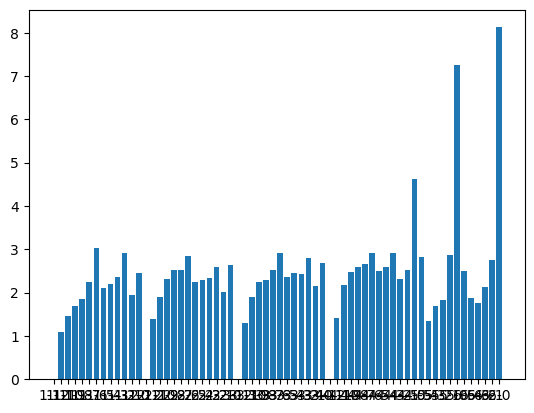

In [20]:
"""cursory charting of the data"""

import matplotlib.pyplot as plt
plt.bar(range(len(final_dict)), final_dict.values())
plt.xticks(range(len(final_dict)), final_dict.keys())
plt.show()

In [22]:
"""select only the relevant minutes (remove -12's and OT)"""
removal_keys = ['1-12','2-12','3-12','4-12','5-5','5-4','5-3','5-2','5-1','5-0','6-5','6-4','6-3','6-2','6-1','6-0']
for key in removal_keys:
    final_dict.pop(key, None)

In [24]:
final_dict

{'1-11': 1.096,
 '1-10': 1.455,
 '1-9': 1.69,
 '1-8': 1.848,
 '1-7': 2.246,
 '1-6': 3.035,
 '1-5': 2.11,
 '1-4': 2.203,
 '1-3': 2.365,
 '1-2': 2.923,
 '1-1': 1.934,
 '1-0': 2.464,
 '2-11': 1.386,
 '2-10': 1.898,
 '2-9': 2.314,
 '2-8': 2.524,
 '2-7': 2.524,
 '2-6': 2.837,
 '2-5': 2.254,
 '2-4': 2.29,
 '2-3': 2.341,
 '2-2': 2.596,
 '2-1': 2.015,
 '2-0': 2.639,
 '3-11': 1.288,
 '3-10': 1.897,
 '3-9': 2.236,
 '3-8': 2.294,
 '3-7': 2.521,
 '3-6': 2.924,
 '3-5': 2.372,
 '3-4': 2.443,
 '3-3': 2.425,
 '3-2': 2.793,
 '3-1': 2.147,
 '3-0': 2.685,
 '4-11': 1.42,
 '4-10': 2.166,
 '4-9': 2.486,
 '4-8': 2.59,
 '4-7': 2.656,
 '4-6': 2.917,
 '4-5': 2.489,
 '4-4': 2.598,
 '4-3': 2.92,
 '4-2': 2.311,
 '4-1': 2.527,
 '4-0': 4.63}

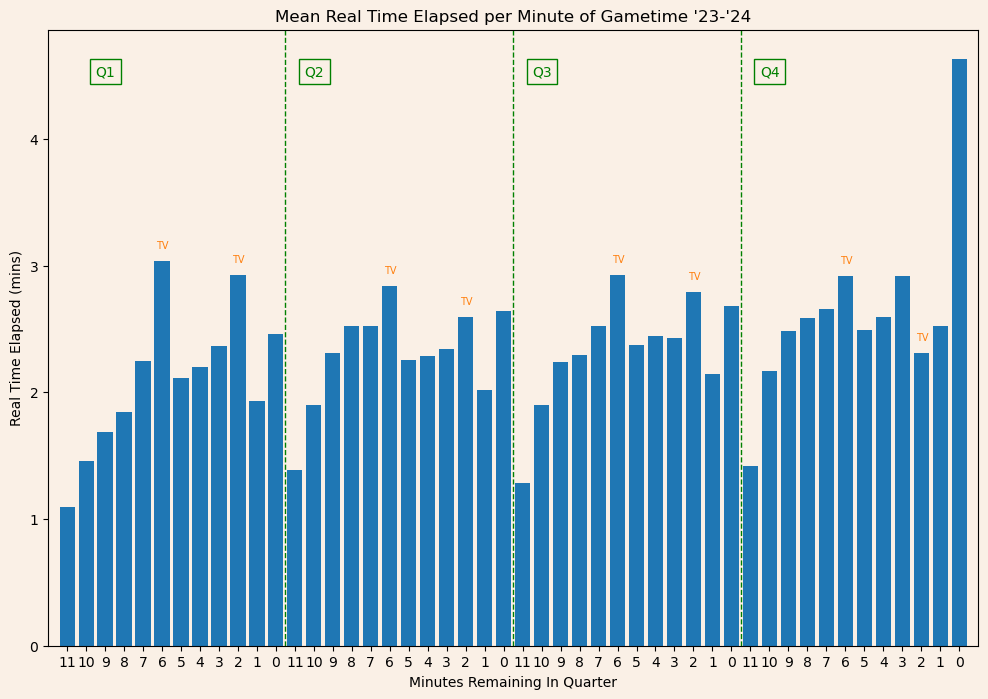

In [58]:
"""making the chart"""
# the plt.figsize below is for jupyter
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8), dpi= 100, facecolor=('linen'))
ax.set_facecolor('linen')
plt.bar(range(len(final_dict)), final_dict.values(), color='tab:blue')
ax.set_xlim(-1,48)

"""vertical lines"""
vlinecoords = [11.5, 23.5, 35.5]
for vcoord in vlinecoords:
    plt.axvline(x=vcoord, color='g', linestyle='--', linewidth=1)
"""ticks"""
minute_labels = [x.partition("-")[2] for x in final_dict.keys()]
plt.xticks(range(len(final_dict)), labels=minute_labels)

"""add annotations for quarter"""
plt.annotate('Q1', xy=(1.5, 4.5), color='green', bbox=dict(facecolor='none', edgecolor='green'))
plt.annotate('Q2', xy=(12.5, 4.5), color='green', bbox=dict(facecolor='none', edgecolor='green'))
plt.annotate('Q3', xy=(24.5, 4.5), color='green', bbox=dict(facecolor='none', edgecolor='green'))
plt.annotate('Q4', xy=(36.5, 4.5), color='green', bbox=dict(facecolor='none', edgecolor='green'))

"""add annotations fo TV timeouts - the x-coordinates need changing"""
plt.annotate('TV', xy=(4.7, list(final_dict.values())[5]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(8.7, list(final_dict.values())[9]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(16.7, list(final_dict.values())[17]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(20.7, list(final_dict.values())[21]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(28.7, list(final_dict.values())[29]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(32.7, list(final_dict.values())[33]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(40.7, list(final_dict.values())[41]+.1), color='tab:orange', fontsize=7)
plt.annotate('TV', xy=(44.7, list(final_dict.values())[45]+.1), color='tab:orange', fontsize=7)

"""axis labels/title"""
plt.xlabel("Minutes Remaining In Quarter")
plt.ylabel("Real Time Elapsed (mins)")
plt.title("Mean Real Time Elapsed per Minute of Gametime '23-'24")

"""plt.figure used above"""
# fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.show()
